## Imports

In [13]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns
import sys
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn import Module, Conv1d, MaxPool1d, Softmax, Linear, Flatten, Dropout
import multiprocessing
from tqdm import tqdm
import itertools
sys.path.append('../src')
from utils import plot_spectrum, filename_from_metadata, load_dataset

In [14]:
torch.manual_seed(12)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
torch.cuda.is_available()

False

# Data preparation
* Variance thresholding
* Normalization so that the mean is 0 and variance is 1

### Load data and split them into features X and target y

In [6]:
data = load_dataset(data_dir='../data/id/', dataset_name='spectrum_exported', verbose=True)
X, y, metadata = data['data_points'], data['data_labels'], data['metadata']

[INFO] Loading dataset spectrum_exported.
[INFO] Dataset spectrum_exported loaded loaded in 6.7 seconds.
[INFO] Input data shapes: X[(23430, 801)], y[(23430,)]


### (Optional) Filter data

### Split into training and testing data + convert test data to PyTorch tensors

In [17]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"Data splitted in {(time.time() - start):.1f} seconds.")

Data splitted in 0.3 seconds.


### Put Data through DataLoader, so we can use batches

In [18]:
class Data(Dataset):
    def __init__(self, x_train, y_train):
        self.x = torch.from_numpy(x_train)
        self.y = torch.from_numpy(y_train)
        self.len = self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

# Modeling

In [19]:
def conv1d_output_size(input_size, out_channels, padding, kernel_size, stride, dilation=None):
    """According to https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    """
    if dilation is None:
        dilation = 1

    output_size = (
        out_channels,
        np.floor((input_size[1] + 2 * padding - dilation *
                  (kernel_size - 1) - 1) / stride + 1).astype(int)
    )
    return output_size

def maxpool1d_output_size(input_size, padding, kernel_size, stride, dilation=None):
    """According to https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
    """
    if dilation is None:
        dilation = 1
        
    output_size = (
        input_size[0],
        np.floor(((input_size[1] + 2 * padding - dilation * (kernel_size - 1) - 1) 
                 / stride) + 1).astype(int)
    )
    return output_size

sample_shape = (1, 801)
c_o = 3
c_o2 = 5
k = 5
s = 1
p = 1
p2 = 2
num_classes = len(np.unique(y))
computed_output_size = conv1d_output_size(
    input_size=sample_shape, out_channels=32, padding=2, kernel_size=5, stride=1)
compute_output_size2 = maxpool1d_output_size(
    input_size=computed_output_size, padding=1, kernel_size=k, stride=2)
computed_output_size3 = conv1d_output_size(
    input_size=compute_output_size2, out_channels=64, padding=2, kernel_size=k, stride=1)
dense_out1 = 60
computed_output_size4 = (computed_output_size3[0], dense_out1)
computed_output_size5 = (computed_output_size4[0] * computed_output_size4[1], )
dense_out2 = 800
computed_output_size6 = (dense_out2, )
computed_output_size7 = (num_classes, )

print(f"Input shape: {sample_shape}")
print(f"Conv1d: {computed_output_size}")
print(f"MaxPool1d: {compute_output_size2}")
print(f"Conv1d: {computed_output_size3}")
print(f"Dense: {computed_output_size4}")
print(f"Flatten: {computed_output_size5}")
print(f"Dense: {computed_output_size6}")
print(f"Dense: {computed_output_size7}")

Input shape: (1, 801)
Conv1d: (32, 801)
MaxPool1d: (32, 400)
Conv1d: (64, 400)
Dense: (64, 60)
Flatten: (3840,)
Dense: (800,)
Dense: (70,)


In [20]:
class SimpleCNN(nn.Module):
    def __init__(self, num_channels, num_classes, dropout_rate):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = Conv1d(in_channels=num_channels, out_channels=32,
                            kernel_size=5, padding=2, stride=1)
        self.maxpool = MaxPool1d(kernel_size=5, stride=2, padding=1)
        self.conv2 = Conv1d(in_channels=32, out_channels=64,
                            kernel_size=5, padding=2, stride=1)
        self.drop1 = Dropout(dropout_rate)
        self.dense1 = Linear(in_features=400, out_features=100)
        self.flatten = Flatten()
        self.drop2 = Dropout(dropout_rate)
        self.dense2 = Linear(in_features=6400, out_features=500)
        self.output = Linear(in_features=500, out_features=num_classes)
    def forward(self, x):
        x = self.maxpool(self.conv1(x))
        x = self.conv2(x)
        x = self.drop1(x)
        x = self.dense1(x)
        x = self.flatten(x)
        x = self.drop2(x)
        x = self.dense2(x)
        x = self.output(x)
        return x

# Training

In [21]:
def train(train_loader, validation_loader, model, optimizer, loss_fn, num_train_samples, num_val_samples, batch_size, n_epochs, device, validation_mode, verbose=False):
    num_train_steps, num_val_steps = num_train_samples // batch_size, num_val_samples // batch_size
    assert validation_mode in ['train_val', 'cross_validation', 'tuning'], "Wrong argument - validation_mode!"
    H = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    if verbose:
        print("[INFO] Training the network...")
        startTime = time.time()
        
    if validation_mode in ['cross_validation', 'tuning']:
        iterator1 = tqdm(range(n_epochs), unit="epoch")
    else:
        iterator1 = range(n_epochs)
    for epoch in iterator1:
        train_loss = 0
        train_correct = 0
        if validation_mode == 'train_val':
            iterator2 = tqdm(train_loader, unit="batch")
        else: 
            iterator2 = train_loader
            if validation_mode in ['cross_validation', 'tuning']:
                iterator1.set_description(f"Epoch {epoch}")
        for batch_n, (xi, yi) in enumerate(iterator2):
            if validation_mode == 'train_val':
                iterator2.set_description(f"Batch {batch_n}")
            xi, yi = xi.to(device), yi.to(device)

            #clear gradient 
            optimizer.zero_grad()

            #make a prediction 
            z = model(xi)

            # calculate loss
            loss = loss_fn(z, yi)

            # calculate gradients of parameters 
            loss.backward()

            # update parameters 
            optimizer.step()

            train_loss += loss
            correct = ((z.argmax(1) == yi).type(torch.float).sum().item())
            train_correct += correct
            accuracy = correct / batch_size

            if validation_mode == 'train_val':
                iterator2.set_postfix(loss=loss.item(), accuracy=100. * accuracy)
        
        # calculate the average training loss
        epoch_train_loss = (train_loss / num_train_steps).item()
        
        # calculate the training accuracy
        epoch_train_correct = train_correct / num_train_samples
        
        # update our training history
        H["train_loss"].append(epoch_train_loss)
        H["train_acc"].append(epoch_train_correct)
        
        if verbose and validation_mode == 'train_val':
            # print the model training and validation information
            print("[INFO] EPOCH: {}/{}".format(epoch + 1, n_epochs))
            print(f"Train loss: {epoch_train_loss:.4f}, Train accuracy: {epoch_train_correct:.4f}")
        elif validation_mode in ['cross_validation', 'tuning']:
            iterator1.set_postfix(loss=epoch_train_loss, accuracy=100. * epoch_train_correct)
        
        if validation_mode == 'train_val':
            val_correct = 0
            val_loss = 0
#             model.eval()
            with torch.no_grad():
                for xi, yi in validation_loader:
                    xi, yi = xi.to(device), yi.to(device)
                    z = model(xi)
                    val_loss += loss_fn(z, yi)
                    val_correct += ((z.argmax(1) == yi).type(torch.float).sum().item())
#             model.train() # -> when doing this it degrades the accuracy by a lot! -> use less for dropout?
            epoch_val_loss = (val_loss / num_val_steps).item()
            epoch_val_correct = val_correct / num_val_samples
            H["val_loss"].append(epoch_val_loss)
            H["val_acc"].append(epoch_val_correct)
            if verbose and validation_mode == 'train_val':
                print(f"Val loss: {epoch_val_loss:.6f}, Val accuracy: {epoch_val_correct:.4f}")
        
    if verbose:
        print(f"[INFO] Total time taken to train the model: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")  
    
    if validation_mode in ['cross_validation', 'tuning']:
        val_correct = 0
        val_loss = 0
        predictions = []
        labels = []
        model.eval()
        with torch.no_grad():
            for xi, yi in validation_loader:
                xi, yi = xi.to(device), yi.to(device)
                z = model(xi)
                y_pred = z.argmax(1).cpu().numpy()
                predictions.append(y_pred)
                labels.append(yi.cpu().numpy())
                val_loss += loss_fn(z, yi)
                val_correct += ((z.argmax(1) == yi).type(torch.float).sum().item())
        val_loss = (val_loss / num_val_steps).item()
        val_correct = val_correct / num_val_samples
        predictions = np.concatenate(predictions, axis=0)
        labels = np.concatenate(labels, axis=0)
        if validation_mode == 'tuning':
            H['test_precision'] = precision_score(y_true=labels, y_pred=predictions, average='macro', zero_division=1)
            H['test_recall'] = recall_score(y_true=labels, y_pred=predictions, average='macro', zero_division=1)
        else:
            H['test_precision'] = precision_score(y_true=labels, y_pred=predictions, average='macro', zero_division='warn')
            H['test_recall'] = recall_score(y_true=labels, y_pred=predictions, average='macro', zero_division='warn')
        H["test_loss"] = val_loss
        H["test_acc"] = val_correct
        return model, H, predictions, labels
        
    return model, H

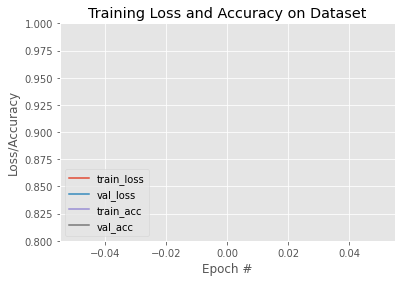

In [171]:
%matplotlib inline
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.ylim([0.8, 1])
# plt.savefig(args["plot"])
plt.show()

### Save the model

In [132]:
timestr = time.strftime("%Y%m%d-%H%M")
optional_flag = 'more_parameters_LR=10e-5'
PATH = f'../models/cnn_{timestr}_{optional_flag}.md'
torch.save(model.state_dict(), PATH)

### Load trained model

# Evaluation of the model using default hyperparameters
* metrics - accuracy, precision, recall, f1-score

# Fine-tuning hyperparameters

#### batch size + number of epochs

In [116]:
startTime = time.time()

param_space = {
    "batch_size": [1, 4, 8, 16, 20, 32],
    "num_epochs": [60, 100, 250]
}

keys, values = zip(*param_space.items())
param_combinations = [v for v in itertools.product(*values)]
param_combinations

X_tune, y_tune = X[:5000], y[:5000]
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=1)

train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)
loss_fn = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-5
DROPOUT_RATE = 0.1
best_score = 0
num_channels = 1
num_classes = 70

grid_search_df = pd.DataFrame(columns=['params', 'accuracy', 'precision', 'recall'])
for (batch_size, n_epochs) in param_combinations:
    init_model = SimpleCNN(num_channels, num_classes, DROPOUT_RATE).to(device)
    optimizer = Adam(init_model.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(
                      dataset=train_dataset, 
                      batch_size=batch_size)
    test_loader = DataLoader(
                      dataset=test_dataset,
                      batch_size=batch_size)
    trained_model, H, _, _ = train(train_loader, 
                             test_loader, 
                             init_model, 
                             optimizer, 
                             loss_fn, 
                             len(train_loader.dataset), 
                             len(test_loader.dataset),
                             batch_size,
                             n_epochs,
                             device, 
                             validation_mode='tuning',
                             verbose=False)
    score = H["test_acc"]
    result = {'params': [batch_size, n_epochs], 
              'accuracy': H['test_acc'], 
              'precision': H['test_precision'], 
              'recall': H['test_recall']}  
    result = pd.DataFrame([result])
    grid_search_df = pd.concat([grid_search_df, result], ignore_index=True)
    print(grid_search_df.iloc[-1])
    if score > best_score:
        best_score = score
        best_parameters = {'batch_size': batch_size, 'num_epochs': n_epochs}
        
print(f"[INFO] total time taken to run grid search: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")          
print(f"Best: {best_score} using {best_parameters}")
grid_search_df.sort_values(['accuracy', 'precision', 'recall'], ascending=False)

Epoch 59: 100%|██████████| 60/60 [07:36<00:00,  7.61s/epoch, accuracy=90.8, loss=25.1] 


params        [1, 60]
accuracy        0.879
precision    0.889577
recall       0.878518
Name: 0, dtype: object


Epoch 99: 100%|██████████| 100/100 [12:47<00:00,  7.67s/epoch, accuracy=93.4, loss=13.4]


params       [1, 100]
accuracy        0.851
precision    0.895264
recall        0.85197
Name: 1, dtype: object


Epoch 249: 100%|██████████| 250/250 [32:18<00:00,  7.75s/epoch, accuracy=98.6, loss=1.37] 


params       [1, 250]
accuracy        0.905
precision    0.916429
recall        0.90852
Name: 2, dtype: object


Epoch 59: 100%|██████████| 60/60 [01:57<00:00,  1.96s/epoch, accuracy=81.3, loss=109]  


params        [4, 60]
accuracy        0.812
precision    0.862595
recall       0.830054
Name: 3, dtype: object


Epoch 99: 100%|██████████| 100/100 [03:15<00:00,  1.96s/epoch, accuracy=88.2, loss=35.3]


params       [4, 100]
accuracy        0.851
precision    0.881489
recall       0.859606
Name: 4, dtype: object


Epoch 249: 100%|██████████| 250/250 [08:10<00:00,  1.96s/epoch, accuracy=95.7, loss=7.49]


params       [4, 250]
accuracy        0.894
precision    0.910432
recall       0.896908
Name: 5, dtype: object


Epoch 59: 100%|██████████| 60/60 [00:59<00:00,  1.01epoch/s, accuracy=77.4, loss=126]  


params        [8, 60]
accuracy         0.76
precision    0.799978
recall       0.764317
Name: 6, dtype: object


Epoch 99: 100%|██████████| 100/100 [01:39<00:00,  1.00epoch/s, accuracy=84.8, loss=68.3]


params       [8, 100]
accuracy        0.846
precision    0.868713
recall       0.853693
Name: 7, dtype: object


Epoch 249: 100%|██████████| 250/250 [04:11<00:00,  1.00s/epoch, accuracy=93.6, loss=10.7]


params       [8, 250]
accuracy        0.882
precision    0.901271
recall       0.886221
Name: 8, dtype: object


Epoch 59: 100%|██████████| 60/60 [00:31<00:00,  1.91epoch/s, accuracy=73.5, loss=142]3]


params       [16, 60]
accuracy        0.784
precision    0.826072
recall       0.790328
Name: 9, dtype: object


Epoch 99: 100%|██████████| 100/100 [00:51<00:00,  1.92epoch/s, accuracy=81.8, loss=58.3]


params       [16, 100]
accuracy          0.82
precision     0.855941
recall        0.824673
Name: 10, dtype: object


Epoch 249: 100%|██████████| 250/250 [02:09<00:00,  1.93epoch/s, accuracy=90.3, loss=22.7]


params       [16, 250]
accuracy         0.859
precision     0.873935
recall         0.86132
Name: 11, dtype: object


Epoch 59: 100%|██████████| 60/60 [00:25<00:00,  2.40epoch/s, accuracy=71.4, loss=203]  


params       [20, 60]
accuracy        0.714
precision    0.804828
recall       0.736112
Name: 12, dtype: object


Epoch 99: 100%|██████████| 100/100 [00:41<00:00,  2.39epoch/s, accuracy=79.4, loss=123] 


params       [20, 100]
accuracy         0.815
precision      0.83852
recall        0.821287
Name: 13, dtype: object


Epoch 249: 100%|██████████| 250/250 [01:44<00:00,  2.39epoch/s, accuracy=90.2, loss=20.6]


params       [20, 250]
accuracy         0.872
precision      0.88638
recall        0.875653
Name: 14, dtype: object


Epoch 59: 100%|██████████| 60/60 [00:16<00:00,  3.67epoch/s, accuracy=68.1, loss=190]    


params       [32, 60]
accuracy        0.735
precision    0.826057
recall       0.742482
Name: 15, dtype: object


Epoch 99: 100%|██████████| 100/100 [00:27<00:00,  3.66epoch/s, accuracy=76.6, loss=84.9]


params       [32, 100]
accuracy         0.805
precision     0.838356
recall        0.803283
Name: 16, dtype: object


Epoch 25:  10%|█         | 25/250 [00:07<01:01,  3.64epoch/s, accuracy=56, loss=440]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [117]:
grid_search_df.sort_values(['accuracy', 'precision', 'recall'], ascending=False)

,params,accuracy,precision,recall
2,"[1, 250]",0.905,0.916429,0.90852
5,"[4, 250]",0.894,0.910432,0.896908
8,"[8, 250]",0.882,0.901271,0.886221
0,"[1, 60]",0.879,0.889577,0.878518
14,"[20, 250]",0.872,0.88638,0.875653
11,"[16, 250]",0.859,0.873935,0.86132
1,"[1, 100]",0.851,0.895264,0.85197
4,"[4, 100]",0.851,0.881489,0.859606
7,"[8, 100]",0.846,0.868713,0.853693
17,"[32, 250]",0.839,0.869217,0.845695


#### Optimizer learning rate

In [118]:
BATCH_SIZE, N_EPOCHS = 4, 250

In [120]:
startTime = time.time()
param_space = {
    "lr": [1e-6, 1e-5, 1e-4, 1e-3]
}

keys, values = zip(*param_space.items())
param_combinations = [v for v in itertools.product(*values)]

X_tune, y_tune = X[:5000], y[:5000]
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=1)

train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)
loss_fn = nn.CrossEntropyLoss()
DROPOUT_RATE = 0.1
best_score = 0
num_channels = 1
num_classes = 70

grid_search_df = pd.DataFrame(columns=['params', 'accuracy', 'precision', 'recall'])
for (learning_rate,) in param_combinations:
    init_model = SimpleCNN(num_channels, num_classes, DROPOUT_RATE).to(device)
    optimizer = Adam(init_model.parameters(), lr=learning_rate)
    train_loader = DataLoader(
                      dataset=train_dataset, 
                      batch_size=BATCH_SIZE)
    test_loader = DataLoader(
                      dataset=test_dataset,
                      batch_size=BATCH_SIZE)
    trained_model, H, _, _ = train(train_loader, 
                             test_loader, 
                             init_model, 
                             optimizer, 
                             loss_fn, 
                             len(train_loader.dataset), 
                             len(test_loader.dataset),
                             BATCH_SIZE,
                             N_EPOCHS,
                             device, 
                             validation_mode='tuning',
                             verbose=False)
    score = H["test_acc"]
    result = {'params': [learning_rate], 
              'accuracy': H['test_acc'], 
              'precision': H['test_precision'], 
              'recall': H['test_recall']}  
    result = pd.DataFrame([result])
    grid_search_df = pd.concat([grid_search_df, result], ignore_index=True)
    print(grid_search_df.iloc[-1])
    if score > best_score:
        best_score = score
        best_parameters = {'learning rate': learning_rate}
   
print(f"[INFO] total time taken to run grid search: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")          
print(f"Best: {best_score} using {best_parameters}")
print(grid_search_df)    

Epoch 249: 100%|██████████| 250/250 [08:11<00:00,  1.97s/epoch, accuracy=75.8, loss=78.3] 


params        [1e-06]
accuracy         0.83
precision    0.850078
recall       0.840684
Name: 0, dtype: object


Epoch 249: 100%|██████████| 250/250 [08:09<00:00,  1.96s/epoch, accuracy=95.5, loss=3.7] 


params        [1e-05]
accuracy        0.883
precision    0.901804
recall       0.883326
Name: 1, dtype: object


Epoch 249: 100%|██████████| 250/250 [08:05<00:00,  1.94s/epoch, accuracy=98.2, loss=8.83]


params       [0.0001]
accuracy        0.872
precision    0.893126
recall       0.879898
Name: 2, dtype: object


Epoch 249: 100%|██████████| 250/250 [08:08<00:00,  1.95s/epoch, accuracy=97.9, loss=6.76e+3]

params        [0.001]
accuracy        0.788
precision    0.810622
recall       0.790528
Name: 3, dtype: object
[INFO] total time taken to run grid search: 1956.15s or 32.60min.
Best: 0.883 using {'learning rate': 1e-05}
     params accuracy precision    recall
0   [1e-06]     0.83  0.850078  0.840684
1   [1e-05]    0.883  0.901804  0.883326
2  [0.0001]    0.872  0.893126  0.879898
3   [0.001]    0.788  0.810622  0.790528


#### Dropout rate 

In [121]:
LEARNING_RATE = 1e-5

In [122]:
startTime = time.time()
param_space = {
    "dropout_rate": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

keys, values = zip(*param_space.items())
param_combinations = [v for v in itertools.product(*values)]

X_tune, y_tune = X[:10000], y[:10000]
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=1)

train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)
loss_fn = nn.CrossEntropyLoss()
best_score = 0
num_channels = 1
num_classes = 70

grid_search_df = pd.DataFrame(columns=['params', 'accuracy', 'precision', 'recall'])
for (dropout_rate,) in param_combinations:
    init_model = SimpleCNN(num_channels, num_classes, dropout_rate).to(device)
    optimizer = Adam(init_model.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(
                      dataset=train_dataset, 
                      batch_size=BATCH_SIZE)
    test_loader = DataLoader(
                      dataset=test_dataset,
                      batch_size=BATCH_SIZE)
    trained_model, H, _, _ = train(train_loader, 
                             test_loader, 
                             init_model, 
                             optimizer, 
                             loss_fn, 
                             len(train_loader.dataset), 
                             len(test_loader.dataset),
                             BATCH_SIZE,
                             N_EPOCHS,
                             device, 
                             validation_mode='tuning',
                             verbose=False)
    score = H["test_acc"]
    result = {'params': [dropout_rate], 
              'accuracy': H['test_acc'], 
              'precision': H['test_precision'], 
              'recall': H['test_recall']}  
    result = pd.DataFrame([result])
    grid_search_df = pd.concat([grid_search_df, result], ignore_index=True)
    print(grid_search_df.iloc[-1])
    if score > best_score:
        best_score = score
        best_parameters = {'dropout rate': dropout_rate}
        
print(f"[INFO] total time taken to run grid search: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")          
print(f"Best: {best_score} using {best_parameters}")
print(grid_search_df)    

Epoch 249: 100%|██████████| 250/250 [15:34<00:00,  3.74s/epoch, accuracy=99.1, loss=0.565]


params          [0.0]
accuracy        0.937
precision    0.936735
recall       0.938202
Name: 0, dtype: object


Epoch 249: 100%|██████████| 250/250 [16:14<00:00,  3.90s/epoch, accuracy=96.8, loss=1.33] 


params          [0.1]
accuracy       0.9225
precision    0.930912
recall       0.924732
Name: 1, dtype: object


Epoch 249: 100%|██████████| 250/250 [16:12<00:00,  3.89s/epoch, accuracy=95.9, loss=2.1] 


params          [0.2]
accuracy        0.926
precision    0.929557
recall       0.925498
Name: 2, dtype: object


Epoch 249: 100%|██████████| 250/250 [16:14<00:00,  3.90s/epoch, accuracy=93.2, loss=3.98]


params          [0.3]
accuracy        0.928
precision    0.936133
recall       0.927217
Name: 3, dtype: object


Epoch 249: 100%|██████████| 250/250 [16:12<00:00,  3.89s/epoch, accuracy=90.9, loss=5.26]


params          [0.4]
accuracy       0.9235
precision    0.925283
recall       0.923018
Name: 4, dtype: object


Epoch 249: 100%|██████████| 250/250 [16:14<00:00,  3.90s/epoch, accuracy=89.4, loss=7.83] 


params          [0.5]
accuracy       0.9275
precision    0.932881
recall       0.927435
Name: 5, dtype: object
[INFO] total time taken to run grid search: 5805.87s or 96.76min.
Best: 0.937 using {'dropout rate': 0.0}
  params accuracy precision    recall
0  [0.0]    0.937  0.936735  0.938202
1  [0.1]   0.9225  0.930912  0.924732
2  [0.2]    0.926  0.929557  0.925498
3  [0.3]    0.928  0.936133  0.927217
4  [0.4]   0.9235  0.925283  0.923018
5  [0.5]   0.9275  0.932881  0.927435


In [123]:
DROPOUT_RATE = 0.2

#### batch size + dropout rate + number of epochs (on whole dataset)

In [18]:
startTime = time.time()

param_space = {
    "batch_size": [32],
    "num_epochs": [200, 300, 400],
    "dropout_rate": [0.1, 0.2, 0.3]
}

keys, values = zip(*param_space.items())
param_combinations = [v for v in itertools.product(*values)]
param_combinations

X_tune, y_tune = X, y
X_train, X_test, y_train, y_test = train_test_split(X_tune, y_tune, test_size=0.2, random_state=1)

train_dataset = Data(X_train, y_train)
test_dataset = Data(X_test, y_test)
loss_fn = nn.CrossEntropyLoss()
num_channels = 1
num_classes = 70
LEARNING_RATE = 1e-5

grid_search_df = pd.DataFrame(columns=['params', 'accuracy', 'precision', 'recall'])
for (batch_size, n_epochs, dropout_rate) in param_combinations:
    init_model = SimpleCNN(num_channels, num_classes, dropout_rate).to(device)
    optimizer = Adam(init_model.parameters(), lr=LEARNING_RATE)
    train_loader = DataLoader(
                      dataset=train_dataset, 
                      batch_size=batch_size)
    test_loader = DataLoader(
                      dataset=test_dataset,
                      batch_size=batch_size)
    trained_model, H, _, _ = train(train_loader, 
                             test_loader, 
                             init_model, 
                             optimizer, 
                             loss_fn, 
                             len(train_loader.dataset), 
                             len(test_loader.dataset),
                             batch_size,
                             n_epochs,
                             device, 
                             validation_mode='tuning',
                             verbose=False)
    score = H["test_acc"]
    result = {'params': [batch_size, n_epochs, dropout_rate], 
              'accuracy': H['test_acc'], 
              'precision': H['test_precision'], 
              'recall': H['test_recall']}  
    result = pd.DataFrame([result])
    grid_search_df = pd.concat([grid_search_df, result], ignore_index=True)
    print(grid_search_df.iloc[-1])
        
print(f"[INFO] total time taken to run grid search: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")          
grid_search_df.sort_values(['accuracy', 'precision', 'recall'], ascending=False)

Epoch 199: 100%|██████████| 200/200 [04:05<00:00,  1.23s/epoch, accuracy=94.3, loss=4.47]


params       [32, 200, 0.1]
accuracy           0.933632
precision          0.942534
recall             0.936891
Name: 0, dtype: object


Epoch 199: 100%|██████████| 200/200 [04:05<00:00,  1.23s/epoch, accuracy=92.2, loss=11.7]


params       [32, 200, 0.2]
accuracy           0.929791
precision          0.938831
recall             0.932727
Name: 1, dtype: object


Epoch 199: 100%|██████████| 200/200 [04:06<00:00,  1.23s/epoch, accuracy=90.9, loss=13.7]


params       [32, 200, 0.3]
accuracy            0.93726
precision          0.944829
recall             0.939401
Name: 2, dtype: object


Epoch 299: 100%|██████████| 300/300 [06:07<00:00,  1.23s/epoch, accuracy=96, loss=3.23]  


params       [32, 300, 0.1]
accuracy           0.928724
precision          0.941363
recall             0.930633
Name: 3, dtype: object


Epoch 299: 100%|██████████| 300/300 [06:08<00:00,  1.23s/epoch, accuracy=94.8, loss=2.73]


params       [32, 300, 0.2]
accuracy           0.946863
precision           0.95141
recall             0.948966
Name: 4, dtype: object


Epoch 299: 100%|██████████| 300/300 [06:07<00:00,  1.22s/epoch, accuracy=93, loss=6.51]  


params       [32, 300, 0.3]
accuracy           0.942595
precision           0.94982
recall             0.942496
Name: 5, dtype: object


Epoch 399: 100%|██████████| 400/400 [08:10<00:00,  1.23s/epoch, accuracy=97.3, loss=0.761]


params       [32, 400, 0.1]
accuracy           0.948997
precision          0.953492
recall             0.950092
Name: 6, dtype: object


Epoch 399: 100%|██████████| 400/400 [08:11<00:00,  1.23s/epoch, accuracy=96.4, loss=0.907]


params       [32, 400, 0.2]
accuracy            0.94921
precision          0.952021
recall             0.952087
Name: 7, dtype: object


Epoch 399: 100%|██████████| 400/400 [08:10<00:00,  1.23s/epoch, accuracy=95.2, loss=1.67]

params       [32, 400, 0.3]
accuracy           0.944302
precision          0.947772
recall             0.946751
Name: 8, dtype: object
[INFO] total time taken to run grid search: 3316.48s or 55.27min.


,params,accuracy,precision,recall
7,"[32, 400, 0.2]",0.94921,0.952021,0.952087
6,"[32, 400, 0.1]",0.948997,0.953492,0.950092
4,"[32, 300, 0.2]",0.946863,0.95141,0.948966
8,"[32, 400, 0.3]",0.944302,0.947772,0.946751
5,"[32, 300, 0.3]",0.942595,0.94982,0.942496
2,"[32, 200, 0.3]",0.93726,0.944829,0.939401
0,"[32, 200, 0.1]",0.933632,0.942534,0.936891
1,"[32, 200, 0.2]",0.929791,0.938831,0.932727
3,"[32, 300, 0.1]",0.928724,0.941363,0.930633


# Final evaluation using all available data with Stratified K-fold Cross-Validation (sklearn)

In [ ]:
LEARNING_RATE = 1e-5
N_EPOCHS = 350
BATCH_SIZE = 32
DROPOUT_RATE = 0.1
num_channels = 1 
num_classes = 70
loss_fn = nn.CrossEntropyLoss()

startTime = time.time()

results = {}
whole_dataset = Data(X, y)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
for fold, (train_ids, test_ids) in enumerate(kfold.split(X, y)):
    print(f"[INFO] Fold #{fold+1}: Starting.")
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    trainloader = DataLoader(
                      dataset=whole_dataset, 
                      batch_size=BATCH_SIZE, 
                      sampler=train_subsampler)
    testloader = DataLoader(
                      dataset=whole_dataset,
                      batch_size=BATCH_SIZE, 
                      sampler=test_subsampler)
    
    model = SimpleCNN(num_channels, num_classes, DROPOUT_RATE).to(device)
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


    # Start training 
    trained_model, H, y_pred, y_true = train(trainloader, 
                                 testloader, 
                                 model, 
                                 optimizer, 
                                 loss_fn, 
                                 len(trainloader.sampler.indices), 
                                 len(testloader.sampler.indices),
                                 BATCH_SIZE,
                                 N_EPOCHS,
                                 device, 
                                 validation_mode='cross_validation',
                                 verbose=True)
    
    if set(y_true) - set(y_pred):
        print(f"[WARNING] Computation of some metrics may be incorrect. \n set(y_true) - set(y_pred) = {set(y_true) - set(y_pred)}")
    print('Training process has finished. Saving trained model.')
    save_path = f'../models/cnn-fold-{fold}.md'
    torch.save(trained_model.state_dict(), save_path)

    # Evaluation for this fold
    print(f'Accuracy for fold #{fold+1}: {(100. * H["test_acc"]):.2f}%')
    print(f'Precision for fold #{fold+1}: {(100. * H["test_precision"]):.2f}%')
    print(f'Recall for fold #{fold+1}: {(100. * H["test_recall"]):.2f}%')
    print(f'Loss for fold #{fold+1}: {H["test_loss"]:.2f}')
    print("================================================")
    results[fold] = H

print("================================================")
print(f"[INFO] total time taken to evaluate the model: {(time.time() - startTime):.2f}s or {(time.time() - startTime)/60:.2f}min.")  
print(f"Results for 5-fold Cross-Validation:")

[INFO] Fold #1: Starting.
[INFO] Training the network...


Epoch 349: 100%|██████████| 350/350 [07:34<00:00,  1.30s/epoch, accuracy=97, loss=2.14]   


[INFO] Total time taken to train the model: 454.79s or 7.58min.
Training process has finished. Saving trained model.
Accuracy for fold #1: 95.67%
Precision for fold #1: 95.95%
Recall for fold #1: 95.69%
Loss for fold #1: 1.76
[INFO] Fold #2: Starting.
[INFO] Training the network...


Epoch 349: 100%|██████████| 350/350 [07:34<00:00,  1.30s/epoch, accuracy=96.8, loss=2.14] 


[INFO] Total time taken to train the model: 454.95s or 7.58min.
Training process has finished. Saving trained model.
Accuracy for fold #2: 95.13%
Precision for fold #2: 95.32%
Recall for fold #2: 95.19%
Loss for fold #2: 5.33
[INFO] Fold #3: Starting.
[INFO] Training the network...


Epoch 349: 100%|██████████| 350/350 [07:35<00:00,  1.30s/epoch, accuracy=96.4, loss=1.7]  


[INFO] Total time taken to train the model: 455.91s or 7.60min.
Training process has finished. Saving trained model.
Accuracy for fold #3: 95.11%
Precision for fold #3: 95.28%
Recall for fold #3: 95.16%
Loss for fold #3: 3.07
[INFO] Fold #4: Starting.
[INFO] Training the network...


Epoch 70:  20%|██        | 70/350 [01:31<06:02,  1.30s/epoch, accuracy=87.8, loss=29.5] 

In [42]:
test_accuracies = np.array([value["test_acc"] for value in results.values()])
test_losses = np.array([value["test_loss"] for value in results.values()])
test_precisions = np.array([value["test_precision"] for value in results.values()])
test_recalls = np.array([value["test_recall"] for value in results.values()])

print("====================================================================")
print(f"Average accuracy across 5-folder: {100. * test_accuracies.mean():.2f}% (std {test_accuracies.std():.2f})")
print(f"Average loss across 5-folder: {test_losses.mean():.2f} (std {test_losses.std():.2f})")
print(f"Average precision across 5-folder: {100. * test_precisions.mean():.2f}% (std {test_precisions.std():.2f})")
print(f"Average recall across 5-folder: {100. * test_recalls.mean():.2f}% (std {test_recalls.std():.2f})")
print("====================================================================")

for i, value in enumerate(results.values()):
    print(f"Fold {i} - Accuracy: {value['test_acc']:.3f}, Precision: {value['test_precision']:.3f}, Recall: {value['test_recall']:.3f}")

Average accuracy across 5-folder: 94.86% (std 0.00)
Average loss across 5-folder: 3.44 (std 1.22)
Average precision across 5-folder: 95.19% (std 0.00)
Average recall across 5-folder: 94.91% (std 0.00)
Fold 0 - Accuracy: 0.949, Precision: 0.951, Recall: 0.949
Fold 1 - Accuracy: 0.951, Precision: 0.956, Recall: 0.951
Fold 2 - Accuracy: 0.950, Precision: 0.952, Recall: 0.951
Fold 3 - Accuracy: 0.946, Precision: 0.951, Recall: 0.947
Fold 4 - Accuracy: 0.947, Precision: 0.950, Recall: 0.948


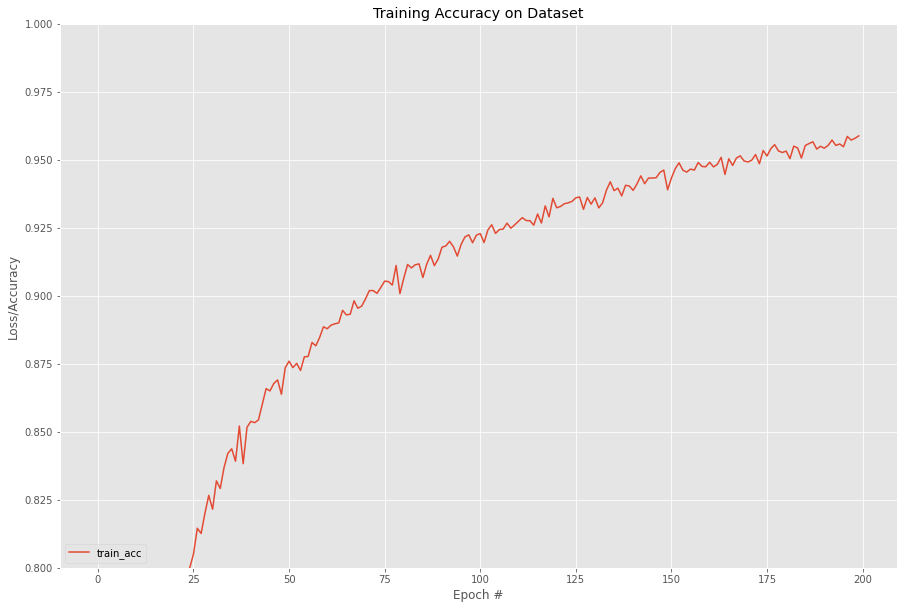

In [45]:
%matplotlib inline
H = results[4]

# plot the training loss and accuracy
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use("ggplot")
plt.figure()
# plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.ylim([0.8, 1])
plt.savefig('../training_acc.png')
plt.show()